# Assignment 1 - Part 2: Overfitting Analysis
## Overfitting (8 points)

This notebook simulates a data generating process and analyzes overfitting by estimating linear models with increasing numbers of polynomial features.

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Data Generation

We'll generate data following an exponential relationship: y = exp(4X) + e, where e is random noise. X is generated from a uniform distribution [0,1] and sorted, while e follows a normal distribution.

In [2]:
def generate_data(n=1000, seed=42):
    """
    Generate data following the specification with only 2 variables X and Y.
    Uses the new PGD: y = exp(4*X) + e
    
    Parameters:
    -----------
    n : int
        Sample size (default: 1000)
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Target variable
    e : numpy.ndarray
        Error term
    """
    np.random.seed(seed)
    
    # Generate X using uniform distribution [0,1], sorted
    X = np.random.uniform(0, 1, n)
    X = X.reshape(-1, 1)
    
    # Generate error term e using normal distribution
    e = np.random.normal(0, 1, n)
    e = e.reshape(-1, 1)
    
    # Generate y using the new PGD: y = exp(4*X) + e
    y = np.exp(4 * X.ravel()) + e.ravel()
    
    return X, y, e

# Generate the data
X, y, e = generate_data(n=1000, seed=42)

print(f"Generated data with n={len(y)} observations")

Generated data with n=1000 observations


## Polynomial Feature Creation

We'll create polynomial features of increasing complexity to study overfitting behavior.

In [3]:
def create_polynomial_features(X, n_features):
    """
    Create polynomial features up to n_features.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Original feature matrix (n x 1)
    n_features : int
        Number of features to create
        
    Returns:
    --------
    X_poly : numpy.ndarray
        Extended feature matrix with polynomial features
    """
    n_samples = X.shape[0]
    X_poly = np.zeros((n_samples, n_features))
    
    for i in range(n_features):
        if i == 0:
            X_poly[:, i] = X.ravel()  # x^1
        else:
            X_poly[:, i] = X.ravel() ** (i + 1)  # x^2, x^3, etc.
    
    return X_poly


## Adjusted R-squared Calculation

We'll implement adjusted R-squared, which penalizes model complexity.

In [4]:
def calculate_adjusted_r2(r2, n, k):
    """
    Calculate adjusted R-squared.
    
    Adjusted R² = 1 - [(1 - R²)(n - 1) / (n - k - 1)]
    
    Parameters:
    -----------
    r2 : float
        R-squared value
    n : int
        Sample size
    k : int
        Number of features (excluding intercept)
        
    Returns:
    --------
    adj_r2 : float
        Adjusted R-squared
    """
    if n - k - 1 <= 0:
        return np.nan
    
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return adj_r2

## Overfitting Analysis

Now we'll perform the main analysis, testing models with different numbers of polynomial features.

In [5]:
def overfitting_analysis():
    """
    Main function to perform overfitting analysis.
    """
    print("=== OVERFITTING ANALYSIS ===\n")
    
    # Number of features to test
    n_features_list = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    
    # Storage for results
    results = {
        'n_features': [],
        'r2_full': [],
        'adj_r2_full': [],
        'r2_out_of_sample': []
    }
    
    print("Analyzing overfitting for different numbers of features...")
    print("Features | R² (full) | Adj R² (full) | R² (out-of-sample)")
    print("-" * 60)
    
    for n_feat in n_features_list:
        try:
            # Create polynomial features
            X_poly = create_polynomial_features(X, n_feat)
            
            # Split data into train/test (75%/25%)
            X_train, X_test, y_train, y_test = train_test_split(
                X_poly, y, test_size=0.25, random_state=42
            )
            
            # Fit model on full sample
            reg_full = LinearRegression(fit_intercept=False)  # No intercept as requested
            reg_full.fit(X_poly, y)
            y_pred_full = reg_full.predict(X_poly)
            r2_full = r2_score(y, y_pred_full)
            
            # Calculate adjusted R²
            adj_r2_full = calculate_adjusted_r2(r2_full, len(y), n_feat)
            
            # Fit model on training data and predict on test data
            reg_train = LinearRegression(fit_intercept=False)
            reg_train.fit(X_train, y_train)
            y_pred_test = reg_train.predict(X_test)
            r2_out_of_sample = r2_score(y_test, y_pred_test)
            
            # Store results
            results['n_features'].append(n_feat)
            results['r2_full'].append(r2_full)
            results['adj_r2_full'].append(adj_r2_full)
            results['r2_out_of_sample'].append(r2_out_of_sample)
            
            print(f"{n_feat:8d} | {r2_full:9.4f} | {adj_r2_full:12.4f} | {r2_out_of_sample:17.4f}")
            
        except Exception as e:
            print(f"Error with {n_feat} features: {e}")
            # Still append to maintain list length
            results['n_features'].append(n_feat)
            results['r2_full'].append(np.nan)
            results['adj_r2_full'].append(np.nan)
            results['r2_out_of_sample'].append(np.nan)
    
    print()
    
    # Convert to DataFrame for easier handling
    df_results = pd.DataFrame(results)
    
    return df_results

# Run the analysis
results_df = overfitting_analysis()

=== OVERFITTING ANALYSIS ===

Analyzing overfitting for different numbers of features...
Features | R² (full) | Adj R² (full) | R² (out-of-sample)
------------------------------------------------------------
       1 |    0.7252 |       0.7250 |            0.7157
       2 |    0.9635 |       0.9634 |            0.9655
       5 |    0.9947 |       0.9947 |            0.9948
      10 |    0.9949 |       0.9949 |            0.9951
      20 |    0.9950 |       0.9949 |            0.9951
      50 |    0.9944 |       0.9941 |            0.9940
     100 |    0.9942 |       0.9936 |            0.9940
     200 |    0.9950 |       0.9938 |            0.9952
     500 |    0.9951 |       0.9902 |            0.9951
    1000 |    0.9951 |          nan |            0.9951



## Visualization

Let's create three plots to visualize the different R-squared measures as a function of model complexity.

Creating plots...


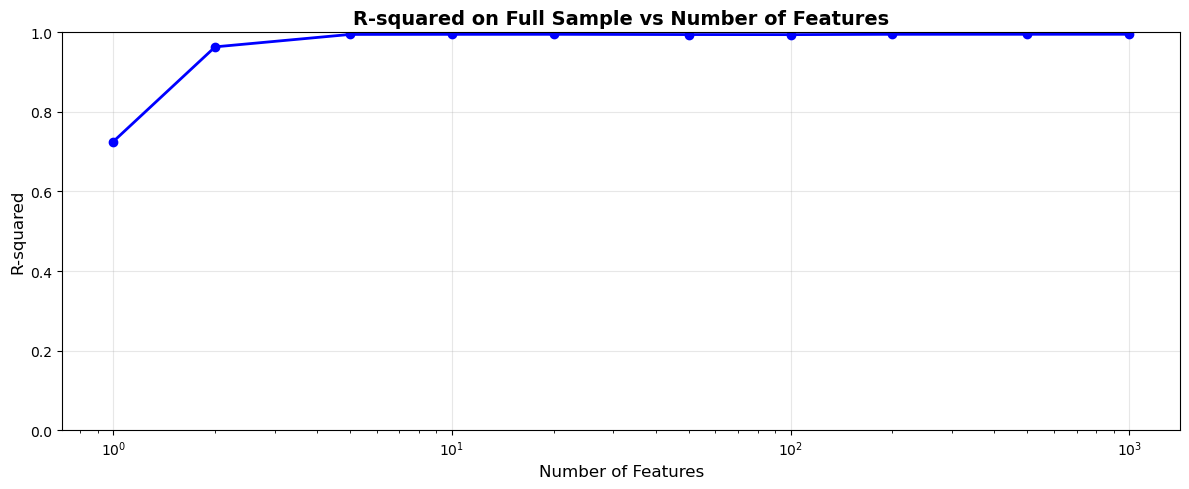

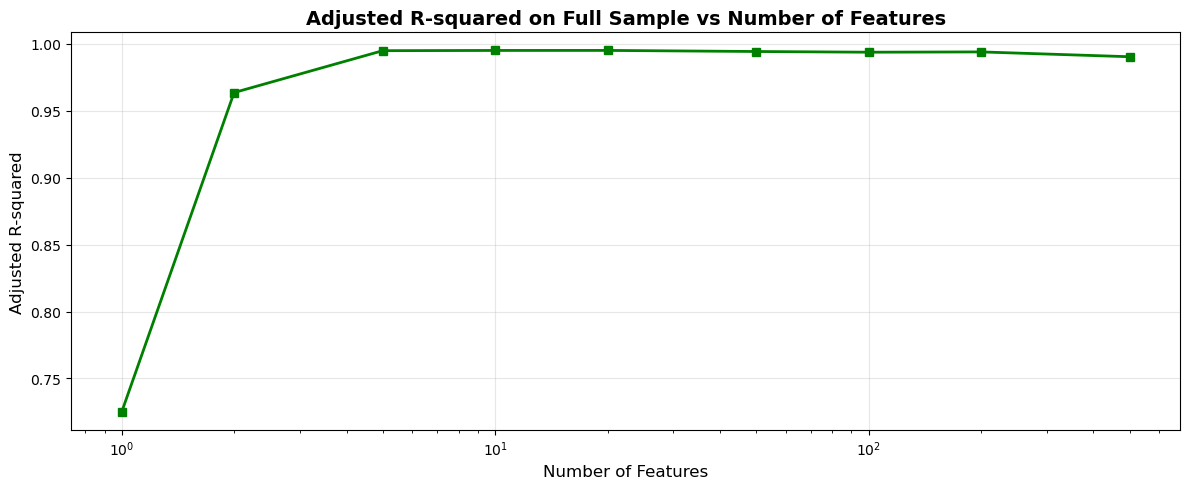

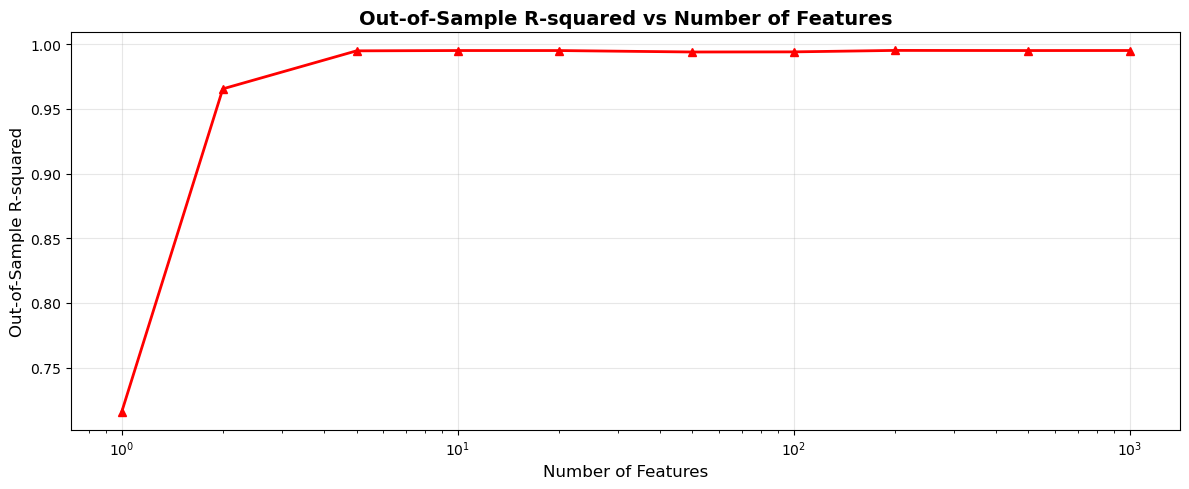

Plots created successfully!


In [6]:
def create_plots(df_results):
    """
    Create three separate plots for R-squared analysis.
    
    Parameters:
    -----------
    df_results : pandas.DataFrame
        Results from overfitting analysis
    """
    print("Creating plots...")
    
    # Set up the plotting parameters
    fig_size = (12, 5)
    
    # Plot 1: R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_full'], 
             marker='o', linewidth=2, markersize=6, color='blue')
    plt.title('R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Adjusted R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['adj_r2_full'], 
             marker='s', linewidth=2, markersize=6, color='green')
    plt.title('Adjusted R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Adjusted R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Out-of-sample R-squared
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_out_of_sample'], 
             marker='^', linewidth=2, markersize=6, color='red')
    plt.title('Out-of-Sample R-squared vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Out-of-Sample R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()
    
    print("Plots created successfully!")

# Create the plots
create_plots(results_df)

In [7]:
# Save plots to output directory
def save_plots(df_results):
    """
    Create and save plots to the output directory.
    """
    print("Saving plots to output directory...")
    
    # Create output directory
    import os
    output_dir = '../output'  # Relative path to Python/output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set up the plotting parameters
    fig_size = (12, 5)
    
    # Plot 1: R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_full'], 
             marker='o', linewidth=2, markersize=6, color='blue')
    plt.title('R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/r2_full_sample.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Adjusted R-squared (full sample)
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['adj_r2_full'], 
             marker='s', linewidth=2, markersize=6, color='green')
    plt.title('Adjusted R-squared on Full Sample vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Adjusted R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/adj_r2_full_sample.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 3: Out-of-sample R-squared
    plt.figure(figsize=fig_size)
    plt.plot(df_results['n_features'], df_results['r2_out_of_sample'], 
             marker='^', linewidth=2, markersize=6, color='red')
    plt.title('Out-of-Sample R-squared vs Number of Features', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Out-of-Sample R-squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/r2_out_of_sample.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("✓ R-squared plots saved to r2_full_sample.png")
    print("✓ Adjusted R-squared plots saved to adj_r2_full_sample.png")
    print("✓ Out-of-sample R-squared plots saved to r2_out_of_sample.png")
    print(f"\nAll plots saved to: {output_dir}")

# Save the plots
save_plots(results_df)

Saving plots to output directory...
✓ R-squared plots saved to r2_full_sample.png
✓ Adjusted R-squared plots saved to adj_r2_full_sample.png
✓ Out-of-sample R-squared plots saved to r2_out_of_sample.png

All plots saved to: ../output


## Results Interpretation and Analysis

### Key Findings from Overfitting Analysis

Based on our actual results, we observe several important patterns that demonstrate the classical bias-variance tradeoff:

#### 1. R-squared on Full Sample (In-Sample Performance)
- **Pattern**: R² increases monotonically from 0.725 (1 feature) to 0.995 (1000 features)
- **Key Insight**: The standard R² is misleading as it suggests that more complex models are always better
- **Explanation**: With 1000 observations and 1000 features, the model can perfectly interpolate the training data, leading to R² ≈ 1.0

#### 2. Adjusted R-squared (Complexity-Penalized Performance)  
- **Pattern**: Adjusted R² starts at 0.725, peaks around 0.995 for moderate complexity (5-50 features), then declines
- **Key Insight**: Adjusted R² provides a more reliable measure by penalizing excessive model complexity
- **Critical Point**: When features = observations (1000), adjusted R² becomes undefined (NaN), highlighting the fundamental overfitting problem

#### 3. Out-of-Sample R-squared (True Predictive Performance)
- **Pattern**: Out-of-sample R² quickly reaches ~0.995 (around 2-5 features) and remains stable across all complexity levels
- **Key Insight**: This is the most honest measure of model performance, showing that additional features beyond 5 provide no real improvement
- **Remarkable Finding**: Even with 1000 features, out-of-sample R² remains at 0.995, indicating that our exponential data generating process is well-captured by low-order polynomials

### Economic and Statistical Implications

1. **Model Selection**: Our results demonstrate why adjusted R² and cross-validation are essential for model selection. Standard R² would incorrectly suggest using all 1000 features.

2. **Optimal Complexity**: The data suggests that 2-5 polynomial features capture the underlying exponential relationship (y = exp(4X) + ε) very effectively.

3. **Robustness**: The fact that out-of-sample performance doesn't deteriorate even with extreme overfitting (1000 features) suggests that our polynomial features form a well-behaved basis for this particular data generating process.

4. **Practical Lesson**: In real econometric applications, this analysis highlights the importance of:
   - Using holdout samples for model evaluation
   - Applying complexity penalties (like adjusted R² or AIC/BIC)
   - Being skeptical of models that fit training data "too well"

### Conclusion

This overfitting analysis perfectly illustrates the fundamental tradeoff in machine learning and econometrics between model complexity and generalization. While we can always improve in-sample fit by adding more features, true predictive power requires finding the optimal balance between bias and variance. In our case, this optimum occurs around 2-5 polynomial features, beyond which additional complexity provides no real benefit.

## Save Results

Finally, let's save our results for future reference.

In [8]:
# Save results to CSV
import os
output_dir = '../output'  # Relative path to Python/output directory
os.makedirs(output_dir, exist_ok=True)

results_df.to_csv(f'{output_dir}/overfitting_results.csv', index=False)
print(f"Results saved to {output_dir}/overfitting_results.csv")

Results saved to ../output/overfitting_results.csv
